# Mini Project IV - Loan Predictions

## Importing data, packages

In [1]:
# import packages for data exploration

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# import csv

df = pd.read_csv("data.csv") 
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [44]:
df.Credit_History.value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [4]:
df.shape

(614, 13)

In [5]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


## Split out train and test

In [6]:
# Drop ID Column

df.drop(['Loan_ID'], axis=1, inplace=True)

In [7]:
# separate out X and y values

X = df.drop(['Loan_Status'], axis=1)
y = df.Loan_Status

In [8]:
# split out test and train data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=808, stratify=y)

## Data Exploration

### Missing Values

In [9]:
# Find missing values in percent

X_train.isna().sum().div(len(X_train)).mul(100).sort_values(ascending=False)

Credit_History       7.739308
Self_Employed        4.684318
LoanAmount           3.462322
Gender               2.240326
Loan_Amount_Term     2.036660
Dependents           1.425662
Property_Area        0.000000
CoapplicantIncome    0.000000
ApplicantIncome      0.000000
Education            0.000000
Married              0.000000
dtype: float64

In [10]:
# don't forget to check target variable

y_train.isna().sum()

0

### Target Feature

<AxesSubplot:>

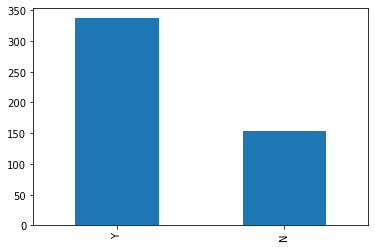

In [11]:
y_train.value_counts().plot(kind='bar')

### Numerical Features

<AxesSubplot:>

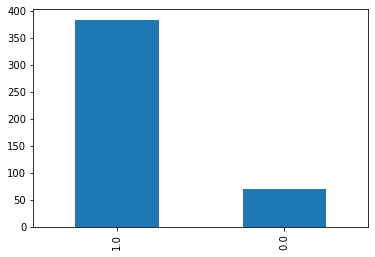

In [12]:
# Credit History distribution

X_train.Credit_History.value_counts().plot(kind='bar')

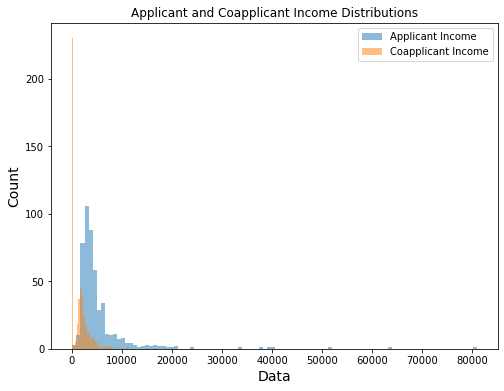

In [13]:
# Applicant Income, Coapplicant Income Distribution

plt.figure(figsize=(8,6))
plt.hist(X_train.ApplicantIncome, bins=100, alpha=0.5, label="Applicant Income")
plt.hist(X_train.CoapplicantIncome, bins=100, alpha=0.5, label="Coapplicant Income")

plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Applicant and Coapplicant Income Distributions")
plt.legend(loc='upper right')

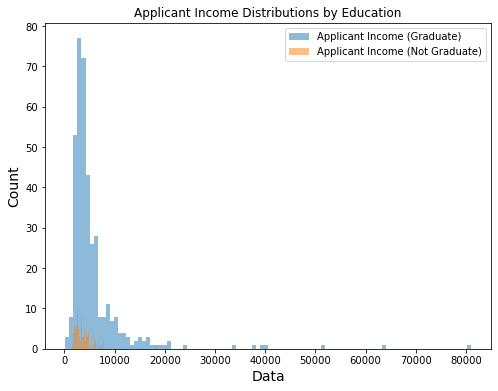

In [14]:
# Distribution of Income filtered by Education Status

plt.figure(figsize=(8,6))
plt.hist(X_train[X_train.Education == 'Graduate']['ApplicantIncome'], bins=100, alpha=0.5, label="Applicant Income (Graduate)")
plt.hist(X_train[X_train.Education == 'Not Graduate']['ApplicantIncome'], bins=100, alpha=0.5, label="Applicant Income (Not Graduate)")

plt.xlabel("Data", size=14)
plt.ylabel("Count", size=14)
plt.title("Applicant Income Distributions by Education")
plt.legend(loc='upper right')

Text(0.5, 1.0, 'Loan Amount Distribution')

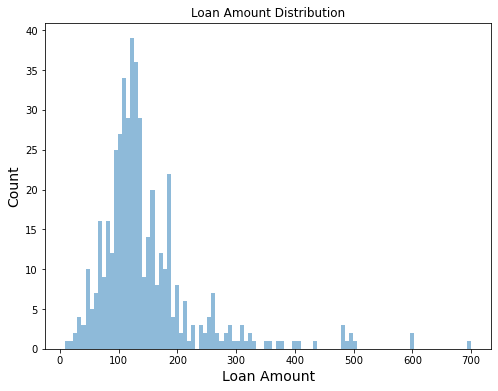

In [15]:
# Loan Amount Distribution

plt.figure(figsize=(8,6))
plt.hist(X_train.LoanAmount, bins=100, alpha=0.5, label="Loan Term")

plt.xlabel("Loan Amount", size=14)
plt.ylabel("Count", size=14)
plt.title("Loan Amount Distribution")

<AxesSubplot:xlabel='LoanAmount', ylabel='Loan_Status'>

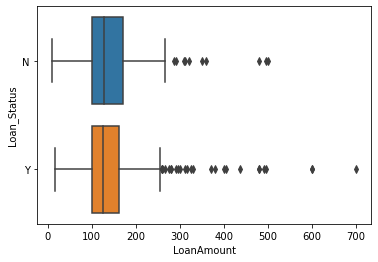

In [16]:
# Loan Amount Boxplot

sns.boxplot(x=X_train.LoanAmount, y=y_train)

### Categorical Features

<AxesSubplot:>

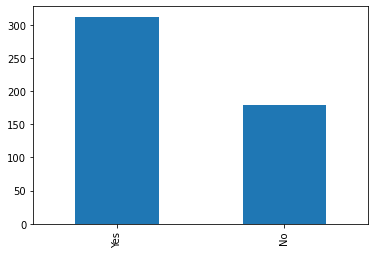

In [17]:
# Married distribution

X_train.Married.value_counts().plot(kind='bar')

<AxesSubplot:>

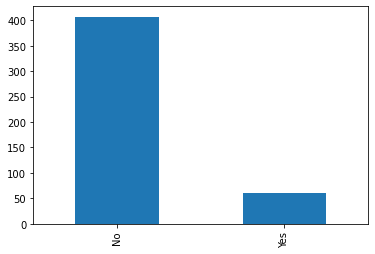

In [18]:
# Self employed distribution

X_train.Self_Employed.value_counts().plot(kind='bar')

<AxesSubplot:>

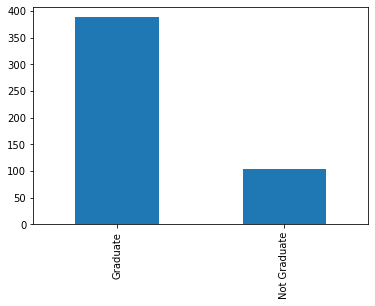

In [19]:
# Education distribution

X_train.Education.value_counts().plot(kind='bar')

<AxesSubplot:>

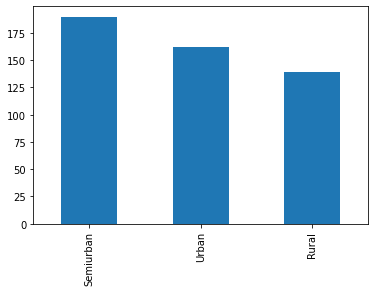

In [20]:
# Property area distribution

X_train.Property_Area.value_counts().plot(kind='bar')

<AxesSubplot:>

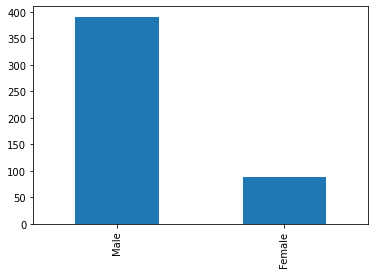

In [21]:
# Gender distribution

X_train.Gender.value_counts().plot(kind='bar')

### Findings

Looks like I will have to:
* Impute (or drop rows with) missing values
* Manage outliers in Loan Amount, Income, Coapp Income
* Manage skew in target categories
* Feature Engineering??
    * Total Income
    * Log of Loan Amount, Income, Coapp
* Onehot for Categorical

## Pre-Modeling Data Steps

# Apply oversampling to training data to deal with class imbalance
# NOTE that this is not in pipeline because it is only done to training data

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=808)
X_train, y_train = ros.fit_resample(X_train, y_train)

# verify resample

y_train.value_counts().plot(kind='bar')

## Construct Pipeline / Build Model

Flow:
* Split between numerical and categorical
* categorical
    * impute missing values (most_frequent)
    * onehot encoding
    * to_dense
    * PCA
* numerical
    * impute missing values (mean)
    * log_transform
    * standard scale
    * variance threshold
    * forward regression
* apply model

In [22]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression


In [23]:
# Get list of column names for categorical, numerical features

cat_feats = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()
num_feats = X_train.dtypes[~X_train.dtypes.index.isin(cat_feats)].index.tolist()

In [24]:
# create to_dense function for use after onehot encoding

def to_dense(x):
    return x.toarray()

to_dense_transformer = FunctionTransformer(to_dense)

In [25]:
# create function to replace 0 with NaN values

def to_nan(x):
    return x.replace(0, np.nan)

to_nan_transformer = FunctionTransformer(to_nan)

In [26]:
# create log transform function

def log_transform(x):
    return np.log(x+1)

log_transformer = FunctionTransformer(log_transform)

In [27]:
# import classifiers

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC



In [28]:
# create numerical processing pipeline

num_processing = Pipeline([('to_nan', to_nan_transformer),
                           ('num_impute', SimpleImputer()),
                           ('log', log_transformer),
                           ('scale', StandardScaler()),
                           ('variance', VarianceThreshold(0.1)),
                           ('kbest', SelectKBest(k=3))
                          ])

In [29]:
# create categorical processing pipeline

cat_processing = Pipeline([('cat_impute', SimpleImputer(strategy='most_frequent')),
                           ('onehot', OneHotEncoder()),
                           ('dense', to_dense_transformer),
                           ('pca', PCA(n_components=3))
                          ])

In [30]:
# combine the two pipelines so they can be fitted to the final pipeline

processing = ColumnTransformer([('numerical', num_processing, num_feats),
                                ('categorical', cat_processing, cat_feats)
                               ])

In [31]:
# assemble final pipeline

pipeline = Pipeline([('processing', processing),
                     ('clf', DecisionTreeClassifier())
                    ])

In [32]:
# mute warnings before fitting pipeline

import warnings
warnings.filterwarnings('ignore')

In [33]:
# fit pipeline to training data

pipeline.fit(X_train, y_train)

Pipeline(steps=[('processing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('to_nan',
                                                                   FunctionTransformer(func=<function to_nan at 0x7ff98076ce50>)),
                                                                  ('num_impute',
                                                                   SimpleImputer()),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x7ff98077b0d0>)),
                                                                  ('scale',
                                                                   StandardScaler()),
                                                                  ('variance',
                                                                   VarianceThre

In [34]:
# check score

pipeline.score(X_test,y_test)

0.6422764227642277

In [35]:
# check confusion matrix

from sklearn import metrics

y_pred = pipeline.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=gridsearch.classes_)
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=gridsearch.classes_)
disp.plot()

NameError: name 'gridsearch' is not defined

## Model Tuning

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
# create parameter grid for tuning

param_grid = [{'processing__numerical__kbest__k': [2,3],
              'processing__categorical__pca__n_components': [2,3,4],
              'clf': [RandomForestClassifier()],
              'clf__n_estimators': [250, 500, 1000],
              'clf__max_depth': [2,4,6]},
              
              {'processing__numerical__kbest__k': [2,3],
              'processing__categorical__pca__n_components': [2,3,4],
              'clf': [GaussianNB()]},
              
              {'processing__numerical__kbest__k': [2,3],
              'processing__categorical__pca__n_components': [2,3,4],
              'clf': [LinearSVC(dual=False)],
              'clf__C': [0.8, 1.0, 1.2],
              'clf__max_iter': [1000, 1500, 2000]}
             ]
              

,
              
              {'processing__numerical__kbest__k': [2,3],
              'processing__categorical__pca__n_components': [2,3,4],
              'clf': [DecisionTreeClassifier()]},

In [38]:
# instantiate gridsearch

gridsearch = GridSearchCV(pipeline, param_grid=param_grid, n_jobs=-1)

In [39]:
# fit gridsearch to training data

gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('processing',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('to_nan',
                                                                                          FunctionTransformer(func=<function to_nan at 0x7ff98076ce50>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('log',
                                                                                          FunctionTransformer(func=<function log_transform at 0x7ff98077b0d0>)),
                                                                                         ('scale',
                                     

In [40]:
# what did gridsearch find as best parameters?

print(gridsearch.best_params_)

{'clf': LinearSVC(C=0.8, dual=False), 'clf__C': 0.8, 'clf__max_iter': 1000, 'processing__categorical__pca__n_components': 2, 'processing__numerical__kbest__k': 2}


### Scoring the Model

In [41]:
# gridsearch final score

print('Final score is: ', gridsearch.score(X_test, y_test))

Final score is:  0.6991869918699187


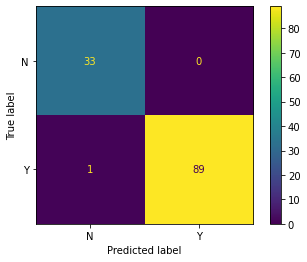

In [55]:
# check confusion matrix

from sklearn import metrics

y_pred = gridsearch.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred, labels=gridsearch.classes_)
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=gridsearch.classes_)
disp.plot()

## Pickle the Model

In [58]:
import pickle

In [59]:
with open('clf.p', 'wb') as fh:
   pickle.dump(gridsearch, fh)